### Loading datasets

In [2]:
import pandas as pd

df_train = pd.read_csv(r"C:\Users\55149\OneDrive\Desktop\CBMET 2024\df_train.csv",index_col=0)
df_test = pd.read_csv(r"C:\Users\55149\OneDrive\Desktop\CBMET 2024\df_test.csv",index_col=0, decimal=',')

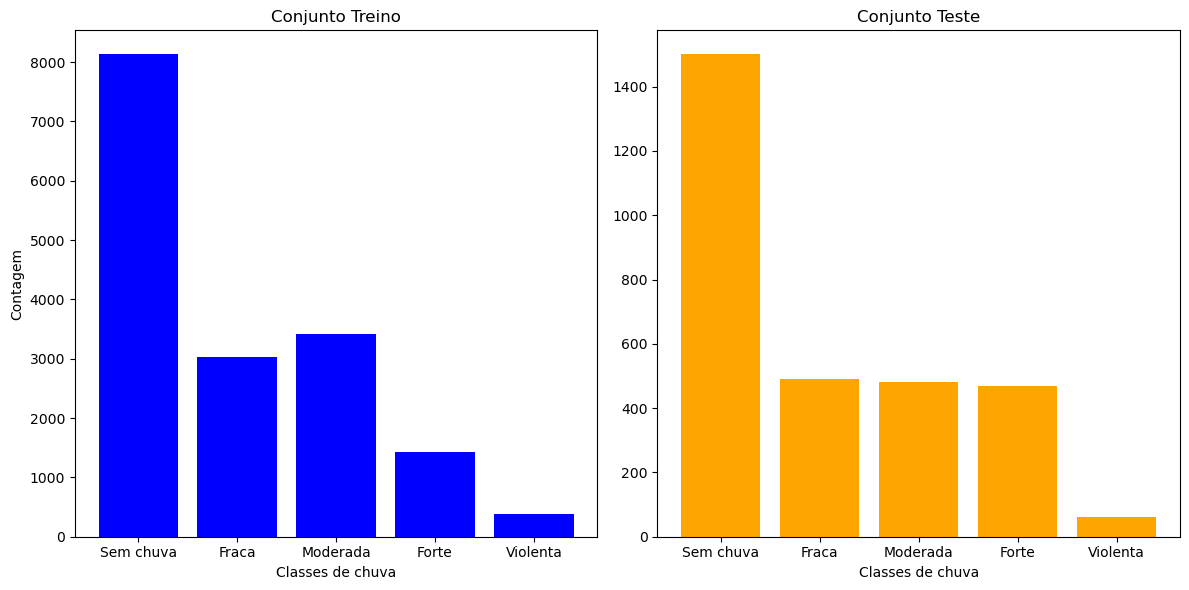

In [3]:
import matplotlib.pyplot as plt

train_counts = df_train.rain_class.value_counts().sort_index()
test_counts = df_test.rain_class.value_counts().sort_index()

# Labels for the bins
labels = ['Sem chuva', 'Fraca', 'Moderada', 'Forte', 'Violenta']

# Create subplots for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the histogram for df_train
axes[0].bar(train_counts.index, train_counts, color='blue')
axes[0].set_title('Conjunto Treino')
axes[0].set_xlabel('Classes de chuva')
axes[0].set_ylabel('Contagem')
axes[0].set_xticks(train_counts.index)
axes[0].set_xticklabels(labels)

# Plot the histogram for df_test
axes[1].bar(test_counts.index, test_counts, color='orange')
axes[1].set_title('Conjunto Teste')
axes[1].set_xlabel('Classes de chuva')
axes[1].set_xticks(test_counts.index)
axes[1].set_xticklabels(labels)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [5]:
df_test.rain_class.value_counts()

0    1500
1     492
2     480
3     468
4      60
Name: rain_class, dtype: int64

### Selecting frequency range according to Xavier et al. (2024)
### 1640-2718 Hz

In [15]:
freqs = np.array(df_train.columns[316:340],dtype=int)
freqs_test = np.array(df_test.columns[356:409],dtype=int)
freqs_test = [freqs_test[np.argmin(np.abs(freqs_test - value))] for value in freqs]
freqs = [str(x) for x in freqs]
freqs_test = [str(x) for x in freqs_test]
sel_col_train = list(df_train.columns[0:281]) + list(freqs)
sel_col_test = list(df_test.columns[0:281]) + freqs_test

df_train = df_train[sel_col_train]
df_test = df_test[sel_col_test]

# Create a mapping from old column names to new column names
column_mapping = {df_test.columns[i]: df_train.columns[i] for i in range(len(df_test.columns))}

# Rename the columns in df_test
df_test.rename(columns=column_mapping, inplace=True)

#### Labeling rain classes
#### rain considers 2 classes: no rain, rain
#### rain_class 2 considers 3 classes: no rain, light/moderate, heavy/violent
#### rain_class considers 5 classes: no rain, light, moderate, heavy, violent

In [16]:
df_train['rain_class2'] = df_train['rain_class'].apply(lambda x: 0 if x == 0 else (1 if x in [1, 2] else 2))

# Create a list of the new column order
new_order = df_train.columns[:-1].tolist()  # All columns except the last one
new_order.insert(2, 'rain_class2')  # Insert the last column into the third position

# Reorder the DataFrame
df_train = df_train[new_order]
df_train.sort_index(inplace=True)

df_test['rain_class2'] = df_test['rain_class'].apply(lambda x: 0 if x == 0 else (1 if x in [1, 2] else 2))

# Create a list of the new column order
new_order = df_test.columns[:-1].tolist()  # All columns except the last one
new_order.insert(2, 'rain_class2')  # Insert the last column into the third position

# Reorder the DataFrame
df_test = df_test[new_order]
df_test.sort_index(inplace=True)

## Part 1: Grid Search for Best Parameters on training dataset
#### This part performs the GridSearchCV for each target (rain, rain_class2, and rain_class) and prints the best parameters found for each target.

In [21]:
MFCC = ['MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 
        'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13']

LPC = ['LPC_1', 'LPC_2', 'LPC_3', 'LPC_4', 'LPC_5', 
       'LPC_6', 'LPC_7', 'LPC_8', 'LPC_9', 'LPC_10']

Hist = list(df_train.columns[3:259])

PSD = list(df_train.columns[282:])

# Define possible feature combinations
feature_sets = {
    'H': Hist,
    'H + MFCC': Hist + MFCC,
    'H + LPC': Hist + LPC,
    'H + PSD': Hist + PSD,
    'H + MFCC + LPC': Hist + MFCC + LPC,
    'H + MFCC + PSD': Hist + MFCC + PSD,
    'H + LPC + PSD': Hist + LPC + PSD,
    'H + MFCC + LPC + PSD': Hist + MFCC + LPC + PSD,
    'MFCC': MFCC,
    'MFCC + LPC': MFCC + LPC,
    'MFCC + PSD': MFCC + PSD,
    'MFCC + LPC + PSD': MFCC + LPC + PSD,
    'LPC': LPC,
    'LPC + PSD': LPC + PSD,
    'H + LPC + PSD': Hist + LPC + PSD,
    'H + MFCC + LPC + PSD': Hist + MFCC + LPC + PSD,
    'PSD': PSD,
    'All_features': df_train.columns[3:]
}

# Target columns
targets = ['rain', 'rain_class2', 'rain_class']

In [94]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Split data
def preprocess_and_split(features, target):
    X = df_train[features]
    y = df_train[target]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Find the best parameters for each target using all features
best_params = {}

for target in targets:
    X_train, X_test, y_train, y_test = preprocess_and_split(feature_sets['All_features'], target)
    
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_params[target] = grid_search.best_params_
    print(f"Best parameters for {target}: {best_params[target]}")

Best parameters for rain: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best parameters for rain_class2: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for rain_class: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


## Part 2: Train and Evaluate with Best Parameters, and Plot Confusion Matrices
#### This part uses the best parameters from the first part to train and evaluate the model on each feature-target combination

In [25]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split data
def preprocess_and_split(features, target):
    X = df_train[features]
    y = df_train[target]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Definir os melhores parâmetros manualmente para cada target
best_params_rain = {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
best_params_rain_class2 = {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
best_params_rain_class = {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

# Dicionário para mapear os parâmetros com os targets correspondentes
best_params_dict = {
    'rain': best_params_rain,
    'rain_class2': best_params_rain_class2,
    'rain_class': best_params_rain_class
}

# Train and evaluate the model for each combination of feature sets and target values
results = []

for feature_name, feature_columns in feature_sets.items():
    for target in targets:
        X_train, X_test, y_train, y_test = preprocess_and_split(feature_columns, target)
        
        # Use the manually defined best parameters for the specific target
        best_rf = RandomForestClassifier(**best_params_dict[target], random_state=42)
        best_rf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = best_rf.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Append results to the list
        results.append({
            'features': feature_name,
            'target': target,
            'accuracy': accuracy,
            'recall': recall,
            'f1': f1
        })

# Convert results to DataFrame and rank by F1 score
results_df = pd.DataFrame(results)
ranked_results = results_df.sort_values(by='f1', ascending=False).reset_index(drop=True)
print(ranked_results)

# Save the results to a CSV file
results_df.to_csv('model_performance_metrics.csv', index=False)
print("Results saved to 'model_performance_metrics.csv'")

# Select the best results for each target
best_rain = ranked_results[ranked_results['target'] == 'rain'].iloc[0]
best_rain_class2 = ranked_results[ranked_results['target'] == 'rain_class2'].iloc[0]
best_rain_class = ranked_results[ranked_results['target'] == 'rain_class'].iloc[0]

                features       target  accuracy    recall        f1
0             MFCC + LPC         rain  0.994304  0.994304  0.994304
1                   MFCC         rain  0.993694  0.993694  0.993694
2             MFCC + PSD         rain  0.990033  0.990033  0.990032
3       MFCC + LPC + PSD         rain  0.989626  0.989626  0.989625
4   H + MFCC + LPC + PSD         rain  0.987795  0.987795  0.987794
5           All_features         rain  0.987795  0.987795  0.987794
6         H + MFCC + PSD         rain  0.986981  0.986981  0.986980
7         H + MFCC + LPC         rain  0.986778  0.986778  0.986778
8          H + LPC + PSD         rain  0.985964  0.985964  0.985963
9               H + MFCC         rain  0.985761  0.985761  0.985760
10             LPC + PSD         rain  0.985761  0.985761  0.985760
11               H + PSD         rain  0.985761  0.985761  0.985759
12                   PSD         rain  0.984337  0.984337  0.984336
13                  MFCC  rain_class2  0.980879 

## Part 3: Confusion Matrices Plotting

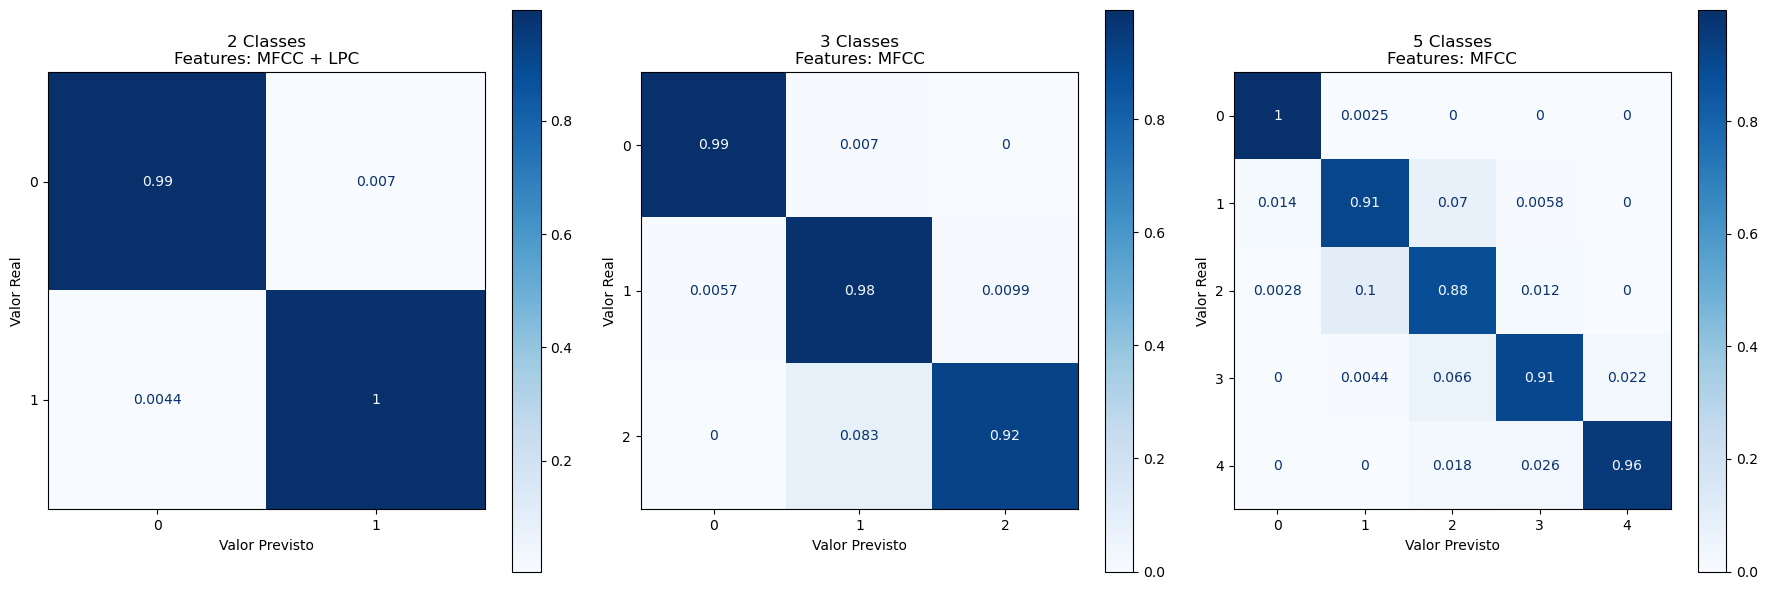

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Parâmetros manuais
best_params = {
    'rain': {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300},
    'rain_class2': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100},
    'rain_class': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
}

# Função para preparar dados e previsões para a matriz de confusão
def get_confusion_matrix_data(best_result):
    X_train, X_test, y_train, y_test = preprocess_and_split(feature_sets[best_result['features']], best_result['target'])
    
    # Treina o modelo com os melhores parâmetros manuais
    best_rf = RandomForestClassifier(**best_params[best_result['target']], random_state=42)
    best_rf.fit(X_train, y_train)
    
    # Previsões
    y_pred = best_rf.predict(X_test)
    
    # Retorna os valores reais e previstos para a matriz de confusão
    return y_test, y_pred

# Obtém os dados das matrizes de confusão para os melhores modelos
y_rain_test, y_rain_pred = get_confusion_matrix_data(best_rain)
y_rain_class2_test, y_rain_class2_pred = get_confusion_matrix_data(best_rain_class2)
y_rain_class_test, y_rain_class_pred = get_confusion_matrix_data(best_rain_class)

# Plota as matrizes de confusão
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Matriz de confusão para o alvo 'rain' (2 classes)
ConfusionMatrixDisplay(confusion_matrix(y_rain_test, y_rain_pred, normalize='true')).plot(ax=ax[0], cmap='Blues')
ax[0].set_title(f"2 Classes\nFeatures: {best_rain['features']}")
ax[0].set_xlabel("Valor Previsto")
ax[0].set_ylabel("Valor Real")

# Matriz de confusão para o alvo 'rain_class2' (3 classes)
ConfusionMatrixDisplay(confusion_matrix(y_rain_class2_test, y_rain_class2_pred, normalize='true')).plot(ax=ax[1], cmap='Blues')
ax[1].set_title(f"3 Classes\nFeatures: {best_rain_class2['features']}")
ax[1].set_xlabel("Valor Previsto")
ax[1].set_ylabel("Valor Real")

# Matriz de confusão para o alvo 'rain_class' (5 classes)
ConfusionMatrixDisplay(confusion_matrix(y_rain_class_test, y_rain_class_pred, normalize='true')).plot(ax=ax[2], cmap='Blues')
ax[2].set_title(f"5 Classes\nFeatures: {best_rain_class['features']}")
ax[2].set_xlabel("Valor Previsto")
ax[2].set_ylabel("Valor Real")

# Ajusta o layout
plt.tight_layout()
plt.show()

## Part 4: Validating model in different location
#### This section uses data from location 1 (IDSM) to train the model and predict values from the data collected at the validation site High Várzea

In [34]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler

# List of targets
targets = ['rain', 'rain_class2', 'rain_class']

# Placeholder for results
results = []

# Function to preprocess data (train and test)
def preprocess_data(feature_columns):
    X_train = df_train.loc[:, feature_columns]
    y_train = df_train[target]
    
    X_test = df_test.loc[:, feature_columns]
    y_test = df_test[target]
    
    # Use MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Train and evaluate the model for each combination of feature sets and target values
for feature_name, feature_columns in feature_sets.items():
    for target in targets:
        # Preprocess the data (no split, just use df_train and df_test)
        X_train, X_test, y_train, y_test = preprocess_data(feature_columns)
        
        # Use the best parameters found in the grid search for this target
        best_rf = RandomForestClassifier(**best_params[target], random_state=42)
        best_rf.fit(X_train, y_train)
        
        # Make predictions on df_test
        y_pred = best_rf.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Append results to the list
        results.append({
            'features': feature_name,
            'target': target,
            'accuracy': accuracy,
            'recall': recall,
            'f1': f1
        })

# Convert results to DataFrame and rank by F1 score
results_df = pd.DataFrame(results)
ranked_results = results_df.sort_values(by='f1', ascending=False).reset_index(drop=True)
print(ranked_results)

# Save the results to a CSV file
results_df.to_csv('validation_performance_metrics.csv', index=False)
print("Results saved to 'validation_performance_metrics.csv'")

# Select the best results for each target
best_rain = ranked_results[ranked_results['target'] == 'rain'].iloc[0]
best_rain_class2 = ranked_results[ranked_results['target'] == 'rain_class2'].iloc[0]
best_rain_class = ranked_results[ranked_results['target'] == 'rain_class'].iloc[0]

                features       target  accuracy    recall        f1
0              LPC + PSD         rain  0.964333  0.964333  0.964309
1                    PSD         rain  0.964000  0.964000  0.963968
2         H + MFCC + PSD         rain  0.957667  0.957667  0.957666
3           All_features         rain  0.957333  0.957333  0.957333
4   H + MFCC + LPC + PSD         rain  0.957333  0.957333  0.957333
5             MFCC + PSD         rain  0.955333  0.955333  0.955325
6       MFCC + LPC + PSD         rain  0.954333  0.954333  0.954329
7                   MFCC         rain  0.952667  0.952667  0.952630
8             MFCC + LPC         rain  0.952333  0.952333  0.952295
9          H + LPC + PSD         rain  0.931667  0.931667  0.931635
10               H + PSD         rain  0.929333  0.929333  0.929295
11              H + MFCC         rain  0.878667  0.878667  0.877181
12        H + MFCC + LPC         rain  0.870000  0.870000  0.868122
13            MFCC + LPC  rain_class2  0.828000 

In [35]:
path =r"C:\Users\55149\OneDrive\Desktop\CBMET 2024\validation_performance_metrics.csv"
results_df.to_csv(path, index=False, decimal=',',sep=';')